In [1]:
!pip install umap-learn
!pip install scikit-learn-extra

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import re
from scipy import sparse

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.8 MB/s eta 0:00:00


2025-05-19 15:52:03.459075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747669923.757152      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747669923.883257      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# -------------------- Load all data --------------------
bert_array = np.load("/kaggle/input/realestate-features-final/bert_embeddings_full.npy")
tfidf_array = sparse.load_npz("/kaggle/input/realestate-features-final/tfidf_features.npz")
structured_df = pd.read_parquet("/kaggle/input/realestate-features-final/structured_features.parquet")
main_df = pd.read_csv("/kaggle/input/last-clean-dataset-re-ranking/cleaned_data.csv")

/tmp/ipykernel_13/2336238244.py:5: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  main_df = pd.read_csv("/kaggle/input/last-clean-dataset-re-ranking/cleaned_data.csv")


In [3]:
# -------------------- Align to same size --------------------
min_len = min(len(bert_array), tfidf_array.shape[0], len(main_df))
bert_array = bert_array[:min_len]
tfidf_array = tfidf_array[:min_len]
main_df = main_df.iloc[:min_len].reset_index(drop=True)

In [4]:
# -------------------- Shuffle the data --------------------
np.random.seed(42)
indices = np.random.permutation(len(main_df))

bert_array = bert_array[indices]
tfidf_array = tfidf_array[indices]
main_df = main_df.iloc[indices].reset_index(drop=True)

In [5]:
# -------------------- Save original order --------------------
original_order = np.argsort(indices) 

In [6]:
# -------------------- SVD --------------------
sample_size = 100000
sample_indices = np.random.choice(tfidf_array.shape[0], sample_size, replace=False)
tfidf_sample = tfidf_array[sample_indices]

svd = TruncatedSVD(n_components=100, random_state=42)
svd.fit(tfidf_sample)

TruncatedSVD(n_components=100, random_state=42)

In [7]:
# -------------------- Transform full TF-IDF in chunks --------------------
batch_size = 10000
tfidf_reduced_chunks = []

for i in range(0, tfidf_array.shape[0], batch_size):
    tfidf_chunk = tfidf_array[i:i+batch_size]
    tfidf_reduced_chunk = svd.transform(tfidf_chunk)
    tfidf_reduced_chunks.append(tfidf_reduced_chunk)

tfidf_reduced = np.vstack(tfidf_reduced_chunks)

In [8]:
# -------------------- Combine All Features --------------------
combined_features = np.hstack([
    bert_array,        # (n, 768)
    tfidf_reduced,     # (n, 100)
])

In [9]:
# -------------------- UMAP to 100D --------------------
sample_indices = np.random.choice(combined_features.shape[0], 100000, replace=False)
umap_model = umap.UMAP(n_components=100, random_state=42)
umap_model.fit(combined_features[sample_indices])

embedding_100d_chunks = []
for i in range(0, combined_features.shape[0], 10000):
    chunk = combined_features[i:i+10000]
    embedded = umap_model.transform(chunk)
    embedding_100d_chunks .append(embedded)

embedding_100d = np.vstack(embedding_100d_chunks)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
# -------------------- Clustering --------------------
scores = {}
best_k, best_score, best_labels = None, -1, None
for k in range(2, 4):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(embedding_100d)
    score = silhouette_score(embedding_100d, labels)
    scores[k] = score
    print(f"k = {k}, Silhouette Score = {score:.4f}")
    if score > best_score:
        best_k, best_score, best_labels = k, score, labels

print(f"\nBest k = {best_k}, silhouette score = {best_score:.4f}")
main_df["writing_cluster"] = best_labels
structured_df["writing_cluster"] = best_labels

k = 2, Silhouette Score = 0.7155
k = 3, Silhouette Score = 0.4040

Best k = 2, silhouette score = 0.7155


In [11]:
# Count number of samples per cluster
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
print(cluster_counts)

0    681777
1     33050
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


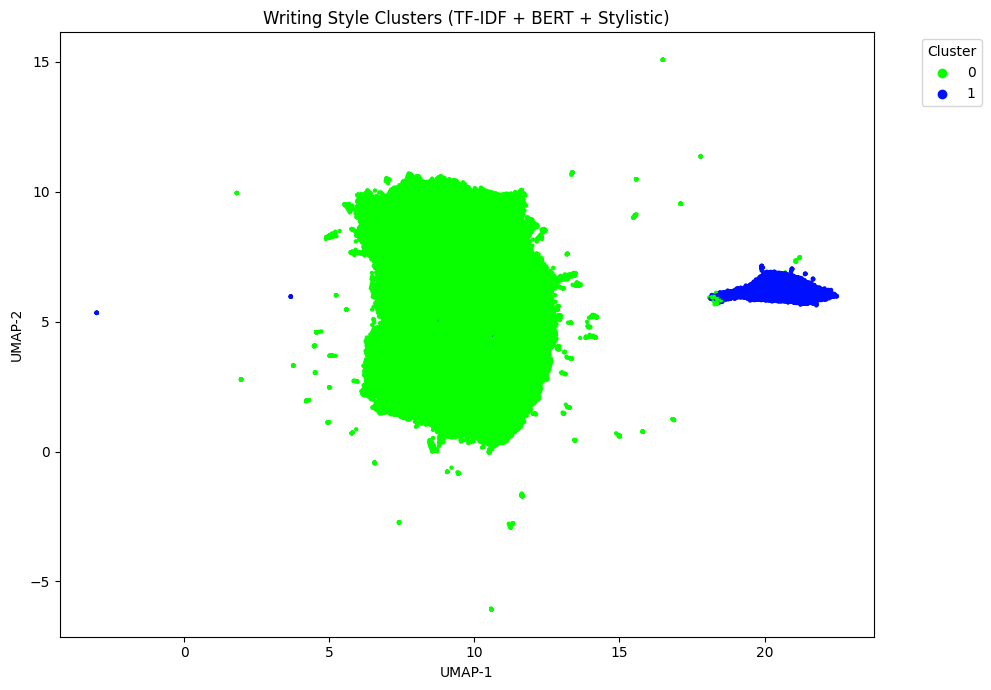

In [12]:
# -------------------- UMAP 2D Visualization --------------------
sample_indices = np.random.choice(len(combined_features), size=100000, replace=False)
sampled_features = combined_features[sample_indices]
sampled_labels = best_labels[sample_indices]

umap_2d = umap.UMAP(n_components=2, random_state=42)
embedding_2d = umap_2d.fit_transform(sampled_features)

np.save("embedding_2d_umap_sample.npy", embedding_2d)
np.save("cluster_labels_sample.npy", sampled_labels)

plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(np.unique(best_labels)))
sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=sampled_labels, palette=palette, s=10, linewidth=0)
plt.title("Writing Style Clusters (TF-IDF + BERT + Stylistic)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("umap_clusters.png", dpi=300)
plt.show()
plt.close()

In [13]:
# -------------------- Save Outputs in Original Order --------------------
structured_df.iloc[original_order].to_csv("real_estate_structured_with_writing_clusters.csv", index=False)
main_df.iloc[original_order].to_csv("real_estate_main_with_clusters.csv", index=False)
np.save("kmeans_cluster_labels.npy", best_labels[original_order])

In [14]:
# -------------------- Cluster Descriptions --------------------
vectorizer_small = TfidfVectorizer(max_features=500)
X_tfidf = vectorizer_small.fit_transform(main_df['description'].fillna(''))
terms = np.array(vectorizer_small.get_feature_names_out())

def describe_cluster(cluster_id, df_main, df_structured, tfidf_matrix, terms):
    mask = df_main['writing_cluster'] == cluster_id
    count = mask.sum()
    mean_len = df_main.loc[mask,'description_length'].mean()
    mean_words = df_main.loc[mask,'description_word_count'].mean()
    mean_price = df_main.loc[mask,'price_per_sqm'].mean()
    mean_amenities = df_main.loc[mask,'total_amenities'].mean()
    mean_construction_year = df_main.loc[mask,'construction_year'].mean()
    mean_bulding_size = df_main.loc[mask,'building_size'].mean()
    
    # ----

    median_len = df_main.loc[mask,'description_length'].median()
    median_words = df_main.loc[mask,'description_word_count'].median()
    median_price = df_main.loc[mask,'price_per_sqm'].median()
    median_amenities = df_main.loc[mask,'total_amenities'].median()
    median_construction_year = df_main.loc[mask,'construction_year'].median()
    median_bulding_size = df_main.loc[mask,'building_size'].median()
    
    cluster_tfidf = tfidf_matrix[mask.values].mean(axis=0).A1
    top_words = terms[np.argsort(cluster_tfidf)[-50:][::-1]]

    desc = f"Cluster {cluster_id} (samples: {count}):\n"
    desc += f"- Mean length: {mean_len:.0f} chars, {mean_words:.0f} words\n"
    desc += f"- Mean price/sqm: {mean_price:.0f}\n"
    desc += f"- Mean amenities: {mean_amenities:.1f}\n"
    desc += f"- Mean building size: {mean_bulding_size:.0f} m²\n"
    desc += f"- Mean construction year: {mean_construction_year:.0f}\n"
    desc += f"- Common words: {' | '.join(top_words)}\n"
    
    # ----
    
    desc += f"- Median length: {median_len:.0f} chars, {median_words:.0f} words\n"
    desc += f"- Median price/sqm: {median_price:.0f}\n"
    desc += f"- Median amenities: {median_amenities:.1f}\n"
    desc += f"- Median building size: {median_bulding_size:.0f} m²\n"
    desc += f"- Median construction year: {median_construction_year:.0f}\n"

    if mean_words < 20 or mean_len < 120 or median_len < 120 or median_words < 20:
        desc += "- Style: Very short and concise\n"
    elif mean_words > 60 or mean_len > 250 or median_words > 60 or median_len >250:
        desc += "- Style: Long and detailed\n"
    else:
        desc += "- Style: Medium-length\n"

    if mean_price > df_main['price_per_sqm'].mean() or median_price > df_main['price_per_sqm'].median():
        desc += "- Ads describe more expensive properties\n"
    else:
        desc += "- Ads often for mid/low-price properties\n"

    if median_bulding_size < df_main['building_size'].median() or mean_bulding_size < df_main['building_size'].mean():
        desc += "- Ads often for bigger properties\n"
    else:
        desc += "- Ads often for mid/small properties\n"
        
    return desc

os.makedirs("cluster_descriptions", exist_ok=True)
descriptions = []
for cid in sorted(main_df['writing_cluster'].unique()):
    text = describe_cluster(cid, main_df, structured_df, X_tfidf, terms)
    descriptions.append(text)
    with open(f"cluster_descriptions/cluster_{cid}_description.txt", "w", encoding="utf-8") as f:
        f.write(text)

with open("cluster_descriptions/all_clusters_summary.txt", "w", encoding="utf-8") as f:
    for text in descriptions:
        f.write(text + "\n" + "-"*50 + "\n")

In [15]:
# -------------------- Summary Table --------------------
# main_df.groupby("writing_cluster")[["price_per_sqm", "description_length", "description_word_count", "building_size", "construction_year"]].agg(['median', 'std', 'mean'])